[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)



# 子图（Sub-graphs）

## 评论（Review）

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

我们正在构建一个多功能的研究助理，它将本课程中的所有模块串联起来。

We just covered parallelization, which is one important LangGraph controllability topic.

我们刚刚介绍了并行化，这是 LangGraph 可控性的一个重要话题。

## 目标（Goals）

Now, we're [going to cover sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example).
## 状态（State）

Sub-graphs allow you to create and manage different states in different parts of your graph. 

子图允许你在图表的不同部分创建和管理不同的状态。

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

这在多智能体系统中尤其有用，尤其是在每个智能体都有各自状态的智能体团队中。

Let's consider a toy example:

让我们考虑一个简单的例子：

* I have a system that accepts logs
* It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
* I want to perform these two operations in two different sub-graphs.

*我有一个接受日志的系统* 它通过不同的代理执行两个独立的子任务（总结日志、查找故障模式）  
* 我希望在这两个不同的子图中执行这两个操作

The most critical thing to understand is how the graphs communicate! 

最重要的是要理解图表是如何传达信息的！

In short, communication is **done with over-lapping keys**: 

简而言之，通信是 **通过重叠密钥** 实现的：

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

*子图可以访问 `docs` 父图中的内容* 父图可以访问 `summary/failure_report` 子图中的内容

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## 输入（Input）

Let's define a schema for the logs that will be input to our graph.

让我们为将输入到我们图形中的日志定义一个模式。



In [ ]:
%%capture --no-stderr
%pip install -U  langgraph

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。



In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

#logs结构
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## 子图（Sub graphs）

Here is the failure analysis sub-graph, which uses `FailureAnalysisState`.

这里是失败分析子图，它使用了 `FailureAnalysisState`。



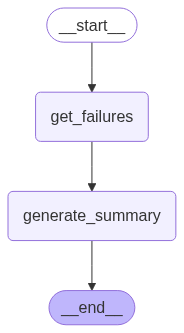

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 故障分析子图
class FailureAnalysisState(TypedDict):
    """用于故障分析的状态。"""
    cleaned_logs: List[Log] # 清理后的日志列表
    failures: List[Log]     # 包含故障的日志列表
    fa_summary: str         # 故障分析摘要
    processed_logs: List[str] # 已处理的日志标识符列表

class FailureAnalysisOutputState(TypedDict):
    """故障分析的输出状态。"""
    fa_summary: str         # 故障分析摘要
    processed_logs: List[str] # 已处理的日志标识符列表

def get_failures(state):
    """获取包含故障的日志"""
    cleaned_logs = state["cleaned_logs"]
    # 从清理后的日志中筛选出包含 "grade" 键的日志，这些被视为故障
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """生成故障摘要"""
    failures = state["failures"]
    # 添加功能：summary = summarize(generate_summary)
    fa_summary = "Chroma 文档的检索质量不佳。"
    # 为每个故障日志生成一个处理过的日志标识符
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Here is the question summarization sub-grap, which uses `QuestionSummarizationState`.

这里是问题总结子图，它使用了 `QuestionSummarizationState`。



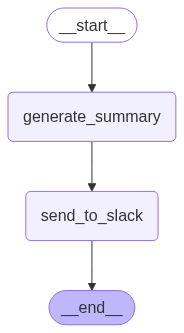

In [4]:
# 摘要生成子图
class QuestionSummarizationState(TypedDict):
    """用于问题摘要的状态。"""
    cleaned_logs: List[Log] # 清理后的日志列表
    qs_summary: str         # 问题摘要
    report: str             # 从摘要生成的报告
    processed_logs: List[str] # 已处理的日志标识符列表

class QuestionSummarizationOutputState(TypedDict):
    """问题摘要的输出状态。"""
    report: str             # 最终报告
    processed_logs: List[str] # 已处理的日志标识符列表

def generate_summary(state):
    """从日志生成摘要。"""
    cleaned_logs = state["cleaned_logs"]
    # 添加功能：summary = summarize(generate_summary)
    summary = "问题集中在 ChatOllama 和 Chroma 向量存储的使用上。"
    # 返回摘要以及已处理的日志ID
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    """模拟发送报告。"""
    qs_summary = state["qs_summary"]
    # 添加功能：report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## 向父图添加子图（Adding sub graphs to our parent graph）

Now, we can bring it all together.

现在，我们可以将所有内容整合在一起。

We create our parent graph with `EntryGraphState`. 

我们使用 `EntryGraphState` 创建父图。

And we add our sub-graphs as nodes! 

并且我们将我们的子图添加为节点！

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```



In [ ]:
# 入口图
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # 这将在两个子图中使用
    fa_summary: str # 这只会在故障分析子图中生成
    report: str # 这只会在问题摘要子图中生成
    processed_logs:  Annotated[List[int], add] # 这将在两个子图中生成

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.

但是，如果 `cleaned_logs` 仅作为输入 *进入* 每个子图，为什么它还需要一个 reducer？它并未被修改。

```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

这是因为子图的输出状态将包含 **所有键**，即使它们未被修改。

The sub-graphs are run in parallel.

子图并行运行。

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.

因为并行子图返回相同的键，因此需要一个像 `operator.add` 这样的缩减器来合并来自每个子图的输入值。

But, we can work around this by using another concept we talked about before.

但是，我们可以通过使用之前讨论过的另一个概念来解决这个问题。

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

我们可以为每个子图简单地创建一个输出状态模式，并确保输出状态模式包含不同的键以作为输出发布。

We don't actually need each sub-graph to output `cleaned_logs`.

我们实际上并不需要每个子图都输出 `cleaned_logs`。



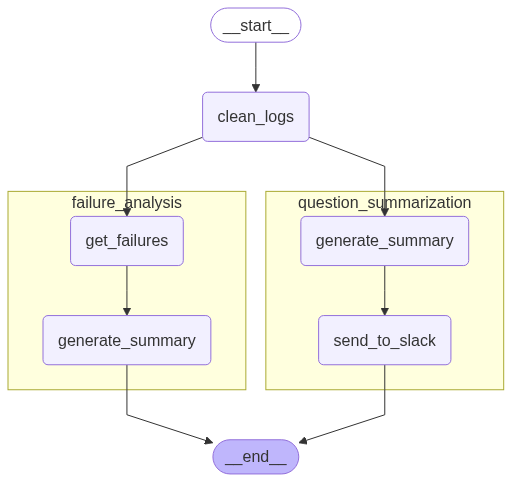

In [ ]:
# 入口图
class EntryGraphState(TypedDict):
    # 原始日志数据列表
    raw_logs: List[Log]
    # 经过清洗处理后的日志数据列表
    cleaned_logs: List[Log]
    fa_summary: str # 这只会在故障分析子图中生成
    report: str # 这只会在问题摘要子图中生成
    processed_logs:  Annotated[List[int], add] # 跟踪哪些日志已经被处理过 ，尤其是在子图之间共享状态时。

def clean_logs(state):
    # 获取日志
    raw_logs = state["raw_logs"]
    # 数据清洗 raw_logs -> docs
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
#添加子图
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# 将 xray 设置为 1 将显示嵌套图的内部结构
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# 模拟日志
question_answer = Log(
    id="1",
    question="我如何导入 ChatOllama?",
    answer="要导入 ChatOllama，请使用：'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="我如何使用 Chroma 向量存储?",
    answer="要使用 Chroma，请定义：rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="文档相关性召回",
    feedback="检索到的文档普遍讨论了向量存储，但没有具体提及 Chroma",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': '我如何导入 ChatOllama?',
   'answer': "要导入 ChatOllama，请使用：'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': '我如何使用 Chroma 向量存储?',
   'answer': '要使用 Chroma，请定义：rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': '文档相关性召回',
   'feedback': '检索到的文档普遍讨论了向量存储，但没有具体提及 Chroma'}],
 'cleaned_logs': [{'id': '1',
   'question': '我如何导入 ChatOllama?',
   'answer': "要导入 ChatOllama，请使用：'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': '我如何使用 Chroma 向量存储?',
   'answer': '要使用 Chroma，请定义：rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': '文档相关性召回',
   'feedback': '检索到的文档普遍讨论了向量存储，但没有具体提及 Chroma'}],
 'fa_summary': 'Chroma 文档的检索质量不佳。',
 'report': 'foo bar baz',
 'processed_logs': ['failure-analysis-on-log-2',
  'summary-on-log-1',
  'summary-on-log-2']}

## 朗史密斯（LangSmith）

Let's look at the LangSmith trace:

让我们来看一下 LangSmith 跟踪记录：

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r

